In [1]:
import pickle
import random as rand
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
import scipy.stats as st
import time
import sys
import os




######################################################
path = "D:\\MsC AI\\1st year\\2nd semester\\3rd period\\Project AI\\Data\\Signal Processing Data\\"
file_name = 'pure_signal_extraction_data.mem'

In [13]:
########################
# HARD CODED VARIABLES #
########################
SAMPLING_RATE = 128 # Approximated value, as sometimes the device misses some recordings

STIMULUS_DURATION_IN_MINUTES = 30
STIMULUS_DURATION = STIMULUS_DURATION_IN_MINUTES*60

SIGNAL_SIZE = SAMPLING_RATE*STIMULUS_DURATION
TIME_STEP = np.arange(SIGNAL_SIZE)

SAMPLE_SIZE = 50
SAMPLE_OVERLAP = 0.5

FINAL_NUMBER_OF_SAMPLES = SIGNAL_SIZE/(SAMPLE_SIZE*SAMPLE_OVERLAP) - 1

MAX_AMPLITUDE = 50
MAX_USUAL_FREQUENCY = 45

NUMBER_OF_TRAINING_INSTANCES = 2
########################
########################

In [6]:
def ass(tail_weigth = .05):
    if np.random.rand() > tail_weigth:
        return np.random.rand()*MAX_USUAL_FREQUENCY
    x = abs(np.random.normal())
    while st.norm.sf(x)>tail_weigth:
        x = abs(np.random.normal())
    return 60 + x - st.norm.ppf(1-tail_weigth)

def extract_from_ass(num_samples, tail_weigth = .05):
    return np.array([ass(tail_weigth) for _ in range(num_samples)])

In [8]:
def generate_pure_signal(initial_frequencies, initial_amplitude, initial_phases, training_instance_number):
    
    FREQUENCY_CHANGE_TIME_STEP = 20
    
    frequencies = list(initial_frequencies)
    amplitudes = list(initial_amplitude)
    phases = list(initial_phases)
    
    pure_signal = []
    
    for current_time_step in TIME_STEP:
        if(current_time_step%FREQUENCY_CHANGE_TIME_STEP == 0 and current_time_step != 0):
            index_to_replace = rand.randint(0, len(frequencies) - 1)
            frequencies[index_to_replace] = ass()
            amplitudes[index_to_replace] = rand.uniform(0, MAX_AMPLITUDE)
            phases[index_to_replace] = rand.uniform(0, 2*np.pi)
            
            #CHANCE OF ADDING NEW RANDOM FREQUENCIES ----> 5% chance
            if(rand.uniform(0, 1) < 0.05):
                for i in range(rand.randint(0, 1)):
                    frequencies.append(ass())
                    amplitudes.append(rand.uniform(0, MAX_AMPLITUDE))
                    phases.append(rand.uniform(0, 2*np.pi))
                    
            #CHANCE OF REMOVING A RANDOM FREQUENCY ----> 5% chance
            if(rand.uniform(0, 1) < 0.05 and len(frequencies) > 1):
                for i in range(rand.randint(0, 1)):
                    index_to_remove = rand.randint(0, len(frequencies) - 1)
                    frequencies.pop(index_to_remove)
                    amplitudes.pop(index_to_remove)
                    phases.pop(index_to_remove)
                    
        current_value = 0
        for j, frequency in enumerate(frequencies):
                current_value += amplitudes[j]*np.sin(phases[j] + 2*np.pi*frequency*current_time_step)
        
        pure_signal.append(current_value)
        
        if(current_time_step%5 == 0 or current_time_step == TIME_STEP[-1]):
            print("\rGenerating Pure Signal. Generated " +
                  str('{:0.5f}').format(100*(current_time_step)/TIME_STEP[-1]) + "% of training instance " + 
                 str(training_instance_number) + " of " + str(NUMBER_OF_TRAINING_INSTANCES) + ".", end="")
        
    return pure_signal

SyntaxError: invalid syntax (<ipython-input-8-c8cd6c26ce7f>, line 42)

In [150]:
def add_noise(pure_signal, training_instance_number, percentage_to_drop = .15):
    AMPLITUDE_CHANGE_TIME_STEP = 10
    MAX_ELECTRICAL_AMPLITUDE = 1 * MAX_AMPLITUDE
    
    # PHASE OF ELECTRICAL SIGNAL SHOULDN'T CHANGE
    RANDOM_PHASE = rand.uniform(0, 2*np.pi)
    
    frequency = 50
    amplitude = rand.uniform(MAX_AMPLITUDE/2, MAX_AMPLITUDE)
    
    noisy_signal = list(pure_signal)
    
    # ADD NOISE AT 50Hz!!!
    for current_time_step in TIME_STEP:
        if(current_time_step%AMPLITUDE_CHANGE_TIME_STEP == 0 and current_time_step != 0):
            amplitude = rand.uniform(MAX_ELECTRICAL_AMPLITUDE/2, MAX_ELECTRICAL_AMPLITUDE)
        
        noisy_electrical_frequency = np.random.normal(frequency, frequency*0.05)
        noisy_signal[current_time_step] += amplitude*np.sin(RANDOM_PHASE + 2*np.pi*noisy_electrical_frequency*current_time_step)
        current_val = noisy_signal[current_time_step]
        noisy_signal[current_time_step] += np.random.normal(current_val, abs(current_val)*0.4)
    
        if(current_time_step%5 == 0 or current_time_step == TIME_STEP[-1]):
            print("\rAdding Noise. Noised " +
                  str('{:0.5f}').format(100*(current_time_step)/TIME_STEP[-1]) + "% of training instance " + 
                 str(training_instance_number) + " of " + str(NUMBER_OF_TRAINING_INSTANCES) + ".", end="")
    
    elements_to_drop = sorted(rand.sample(range(SIGNAL_SIZE), int(SIGNAL_SIZE*percentage_to_drop)), key=int)
    
    print("\rAdding Noise. Randomly Dropping Samples of training instance " + 
                 str(training_instance_number) + " of " + str(NUMBER_OF_TRAINING_INSTANCES) + ".", end="")
    
    for index in sorted(elements_to_drop, reverse=True):
        del noisy_signal[index]
        
    return noisy_signal

In [148]:
def estimate_noisy_signal_missing_values(noisy_signal, training_instance_number):
    
    no_missing_noisy_signal = [-1]*SIGNAL_SIZE
    
    ordered_indices = sorted(rand.sample(range(1, len(no_missing_noisy_signal)-1), len(noisy_signal)-2), key=int)
    
    no_missing_noisy_signal[0] = noisy_signal[0]
    no_missing_noisy_signal[-1] = noisy_signal[-1]
    for i, index in enumerate(ordered_indices):
        no_missing_noisy_signal[index] = noisy_signal[i+1]
    
    for index, val in enumerate(b):
        if(val == -1):
            no_missing_noisy_signal[index] = (no_missing_noisy_signal[index-1]+no_missing_noisy_signal[index+1])/2
        if(index%5 == 0 or index == len(b) - 1):
            print("\rEstimating Signal's Missing Values. Estimated " +
                  str('{:0.5f}').format(100*(index+1)/len(b)) + "% of training instance " + 
                 str(training_instance_number) + " of " + str(NUMBER_OF_TRAINING_INSTANCES) + ".", end="")
    
    
    return no_missing_noisy_signal

# DATA CREATION SECTION

In [ ]:
def create_data():
    
    if os.path.exists(path + file_name):
        append_write = 'ab' # append if already exists
    else:
        append_write = 'wb' # make a new file if not
    
    with open(path + file_name, append_write) as output_file:
        for i in range(NUMBER_OF_TRAINING_INSTANCES):
            INITIAL_NUMBER_OF_FREQUENCIES = rand.randint(1, 4)

            initial_frequencies = []
            initial_amplitudes = []
            initial_phases = []

            for j in range(INITIAL_NUMBER_OF_FREQUENCIES):
                initial_frequencies.append(ass())
                initial_amplitudes.append(rand.uniform(0, MAX_AMPLITUDE))
                initial_phases.append(rand.uniform(0, 2*np.pi))
                

            pure_signal = generate_pure_signal(initial_frequencies, initial_amplitudes, initial_phases, i+1)
            noisy_signal = add_noise(pure_signal, i+1)
            eeg_like_signal = estimate_noisy_signal_missing_values(noisy_signal, i+1)

            pickle.dump([eeg_like_signal, pure_signal], output_file)
            
        
start_time = time.time()
create_data()
print("Time Taken: " + str(time.time() - start_time))

# ----------
# Trainer
# ----------

# Variables

In [2]:
data_name = "pure_signal_extraction_data.mem"

# Random Signal Instance Loader

In [6]:
# DETERMINES THE INDICES POSITIONS


indices = [0]

with open(data_name, "rb") as input_file:
    try:
        while True:
            pickle.load(input_file)
            indices.append(input_file.tell())
    except EOFError:
        pass

    
with open("pure_signal_extraction_data_indices.mem", "wb") as output_file:
    pickle.dump(indices, output_file)
    
print(indices)

[0, 14285092, 28570184, 42855276, 57140368, 71425460, 85710552, 99995644, 114280736, 128565828, 142850920, 157136012, 171421104, 185706196, 199991288, 214276380, 228561472, 242846564, 257131656, 271416748, 285701840, 299986932, 314272024, 328557116, 342842208, 357127300, 371412392, 385697484, 399982576, 414267668, 428552760, 442837852, 457122944, 471408036, 485693128, 499978220, 514263312, 528548404, 542833496, 557118588, 571403680, 585688772, 599973864, 614258956, 628544048, 642829140, 657114232, 671399324, 685684416, 699969508, 714254600, 728539692, 742824784, 757109876, 771394968, 785680060, 799965152, 814250244, 828535336, 842820428, 857105520, 871390612, 885675704, 899960796, 914245888, 928530980, 942816072, 957101164, 971386256, 985671348, 999956440, 1014241532, 1028526624, 1042811716, 1057096808, 1071381900, 1085666992, 1099952084, 1114237176, 1128522268, 1142807360, 1157092452, 1171377544, 1185662636, 1199947728, 1214232820, 1228517912, 1242803004, 1257088096, 1271373188, 12856

In [10]:
def random_signal_loader(static_indices, shuffled_non_static_indices, file_path):
    training_instance = False
    
    if(len(shuffled_non_static_indices) == 0):
        shuffled_non_static_indices = list(static_indices)
        rand.shuffle(shuffled_non_static_indices)
    with open(file_path, "rb") as input_file:
        input_file.seek(shuffled_non_static_indices[0])
        training_instance = pickle.load(input_file)
        
    return training_instance, shuffled_non_static_indices

# ----------------------
# TESTING AREA
# ----------------------

# Estimation of what final data will take in memory

In [127]:
# ESTIMATE SIZE IN MEMORY OF NUMBER OF INSTANCES FOR HALF A HOUR OF DATA COLLECTION AT 128 SAMPLES PER SECOND
number_of_training_instances_to_estimate = 215

with open(path + "pure_signal_extraction_data_toy.mem", "rb") as input_file:
    data = pickle.load(input_file)


size_of_data_when_training = number_of_training_instances_to_estimate*2*sys.getsizeof(data[0][0][0])*SAMPLE_SIZE*FINAL_NUMBER_OF_SAMPLES/1073741824

print("Size of Data in memory when training is approximately: " +
          str(size_of_data_when_training) + " GB.")
print("Producing this amount of Data will take approximately: " +
          str(215*number_of_training_instances_to_estimate/3600) + " hours.")

Size of Data in memory when training is approximately: 5.9045106172561646 GB.
Producing this amount of Data will take approximately: 12.840277777777779 hours.


230400
Size of Data in memory is approximately: 28.125 MB.


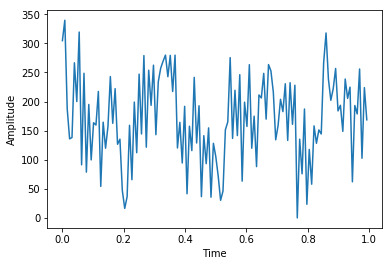

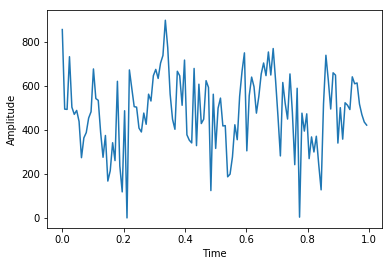

In [20]:
with open("pure_signal_extraction_data_indices.mem", "rb") as input_file:
    indices = pickle.load(input_file)

shuffled_indices = []
data, shuffled_indices = random_signal_loader(indices, shuffled_indices, "pure_signal_extraction_data.mem")

print(len(data[0]))

print("Size of Data in memory is approximately: " +
          str(NUMBER_OF_TRAINING_INSTANCES*2*sys.getsizeof(data[0][0])*len(data[0])/1048576) + " MB.")

init_val = 2500

## FROM THE BEGINNING
#pure_signal = data[0][1][init_val:init_val+128]
#no_missing_noisy_signal = data[0][0][init_val:init_val+128]

## FROM THE END
pure_signal = data[1][-(init_val+128):-init_val]
no_missing_noisy_signal = data[0][-(init_val+128):-init_val]

plt.plot(np.arange(len(pure_signal))/SAMPLING_RATE, pure_signal - min(pure_signal))
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

plt.plot(np.arange(len(no_missing_noisy_signal))/SAMPLING_RATE, no_missing_noisy_signal - min(no_missing_noisy_signal))
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

[28.375743827459466, 21.22567813686863]
[18.56273396592613, 4.456852368488401]
[1.9556386714753822, 2.4596984736089276]
Length of Pure Signal: 256


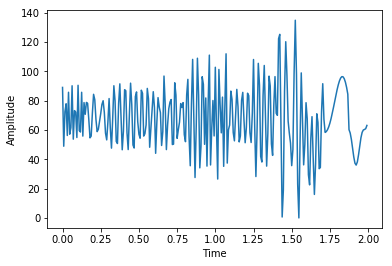

Length of Noisy Signal: 218


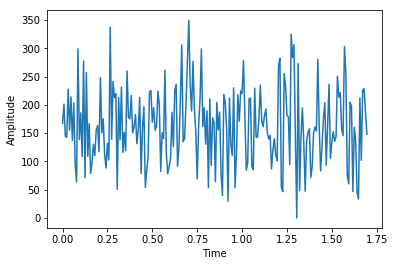

TIME TAKEN NEW: 0.0010013580322265625
Length of No Missing Noisy Signal: 256


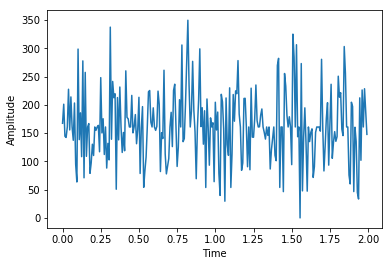

In [140]:
INITIAL_NUMBER_OF_FREQUENCIES = rand.randint(2, 3)

initial_frequencies = []
initial_amplitudes = []
initial_phases = []

for i in range(INITIAL_NUMBER_OF_FREQUENCIES):
    initial_frequencies.append(ass())
    initial_amplitudes.append(rand.uniform(0, MAX_AMPLITUDE))
    initial_phases.append(rand.uniform(0, 2*np.pi))
    
print(initial_frequencies)
print(initial_amplitudes)
print(initial_phases)
    
pure_signal = generate_pure_signal(initial_frequencies, initial_amplitudes, initial_phases, 1)
print("Length of Pure Signal: " + str(len(pure_signal)))

plt.plot(TIME_STEP/SAMPLING_RATE, pure_signal - min(pure_signal))
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


noisy_signal = add_noise(pure_signal, 1)
print("Length of Noisy Signal: " + str(len(noisy_signal)))

plt.plot(np.arange(len(noisy_signal))/SAMPLING_RATE, noisy_signal - min(noisy_signal))
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


no_missing_noisy_signal = estimate_noisy_signal_missing_values(noisy_signal, 1)
print("Length of No Missing Noisy Signal: " + str(len(no_missing_noisy_signal)))

plt.plot(np.arange(len(no_missing_noisy_signal))/SAMPLING_RATE, no_missing_noisy_signal - min(no_missing_noisy_signal))
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

[40.20636528074707, 31.129936300813245]
[1.2301189190870039, 1.7258018633955636]
Sampling Rate: 128.0
Frequency Band: [0 ; 64.0]
Length a: 256
Highest Amplitude Frequencies: [ 0.    0.25  0.5   0.75  1.5 ]


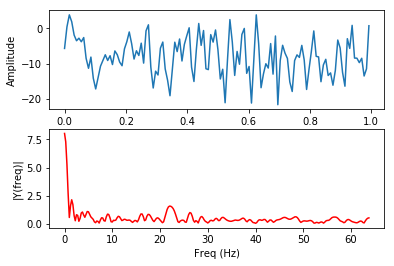

In [154]:
def plotSpectrum(y,Sr, ratio_of_bins, stimulus_time, top_N_frequencies=3):
    """Plots a Single-Sided Amplitude Spectrum of y(t)"""
    n = len(y) # length of the signal
    
    k = np.arange(n*ratio_of_bins)
    T = n*ratio_of_bins/Sr
    
    frq = k/T # two sides frequency range
    frq = frq[range(n*ratio_of_bins//2)] # one side frequency range

    Y = fft(y, int(ratio_of_bins*n))/n # fft computing and normalization
    Y = Y[range(n*ratio_of_bins//2)]
    a = np.array(np.abs(Y))
    print("Length a: " + str(len(a)))
    #print("Highest Amplitude Frequency: " + str(np.argmax(a)/(ratio_of_bins*stimulus_time)))
    ordered_array = np.copy(a)
    ordered_array = ordered_array.argsort()[-top_N_frequencies:][::-1]/(ratio_of_bins*stimulus_time)
    print("Highest Amplitude Frequencies: " +
          str(ordered_array))

    plt.plot(frq,abs(Y),'r') # plotting the spectrum
    plt.xlabel('Freq (Hz)')
    plt.ylabel('|Y(freq)|')
    

INITIAL_NUMBER_OF_FREQUENCIES = rand.randint(2, 3)

initial_frequencies = []
initial_amplitudes = []

for i in range(INITIAL_NUMBER_OF_FREQUENCIES):
    initial_frequencies.append(ass())
    initial_amplitudes.append(rand.uniform(0, MAX_AMPLITUDE))
    
print(initial_frequencies)
print(initial_amplitudes)    
    
signal_data = generate_pure_signal(initial_frequencies, initial_amplitudes)
signal_data = add_noise(signal_data)
signal_data = estimate_noisy_signal_missing_values(signal_data)
number_of_samples = SIGNAL_SIZE

ratio_of_bins = 4
stimulus_time = STIMULUS_DURATION
Sr = number_of_samples/stimulus_time;  # sampling rate
print("Sampling Rate: " + str(Sr))
Ts = 1/Sr; # sampling interval
t = np.arange(0,stimulus_time,Ts) # time vector


print("Frequency Band: [" + str(0) + " ; " + str(Sr/2) + "]")

plt.subplot(2,1,1)
plt.plot(t,signal_data)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.subplot(2,1,2)
plotSpectrum(signal_data, Sr, ratio_of_bins, stimulus_time, top_N_frequencies = 5)
plt.show()

# OLD CODE THAT HAS BEEN IMPROVED

In [134]:
def estimate_noisy_signal_missing_values_OLD(noisy_signal, training_instance_number):
    
    no_missing_noisy_signal = list(noisy_signal)
    
    #print("\rEstimating Noisy Signal Missing Values of training instance " + 
    #         str(training_instance_number) + " of " + str(NUMBER_OF_TRAINING_INSTANCES) + ".", end="")
    
    while(len(no_missing_noisy_signal) < SIGNAL_SIZE):
        i = rand.randint(1, len(no_missing_noisy_signal) - 2) # IGNORES THE BEGINNING AND END OF THE LIST
        estimated_element = (no_missing_noisy_signal[i - 1] + no_missing_noisy_signal[i + 1])/2
        no_missing_noisy_signal = no_missing_noisy_signal[:i] + [estimated_element] + no_missing_noisy_signal[i:]
        
    return no_missing_noisy_signal